##### Time Series Tasks

1. Convert the longitudinal blood pressure measurements into a proper time series:
   - Create a pandas Series with DatetimeIndex using `visit_date`
   - Handle any missing or duplicate measurements appropriately
   - Tips: 
     - Use `pd.to_datetime()` with format='%Y-%m-%d' for reliable parsing
     - Handle duplicates with `duplicated()` and appropriate aggregation
     - Consider timezone handling with `tz_localize()` if needed
     - Use `interpolate()` or `fillna()` for missing values

2. Analyze blood pressure trends:
   - Resample the data to monthly frequency using mean aggregation
   - Calculate 3-month moving averages to smooth out short-term fluctuations
   - Visualize both the original and smoothed trends
   - Tips:
     - Use `resample('ME').mean()` for month-end frequency
     - Add `min_periods` to `rolling()` to handle edge cases
     - Consider `interpolate()` method for gaps
     - Use `ewm()` for exponential weighted alternatives


In [2]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate, learning_curve
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score, precision_recall_curve, precision_recall_fscore_support

In [3]:
#Time Series Data
baseline_data = pd.read_csv('patient_baseline.csv', sep='\t')
longitudinal_data = pd.read_csv('patient_longitudinal.csv', sep='\t')
treatment_data = pd.read_csv('patient_treatment.csv', sep='\t')

In [4]:
#dropped duplicate columns across all 3 tables

dropped_cols = ['age', 'sex', 'bmi', 'smoking' ,'diabetes']
treatment_data.drop(dropped_cols, axis=1, inplace = True)
longitudinal_data.drop(dropped_cols, axis=1, inplace = True)

In [5]:
#further dropped cols
dropped_cols = ['bp_systolic', 'cholesterol', 'heart_rate']
treatment_data.drop(dropped_cols, axis=1, inplace = True)

In [6]:
#combine dataset into one big one for easier analysis and usability
combined_data = pd.merge(baseline_data, longitudinal_data, on = 'patient_id', suffixes=('_baseline', '_longitudinal'))

In [7]:
full_data = pd.merge(combined_data, treatment_data, on = 'patient_id', suffixes=('', 'treatment'))

In [8]:
#convert visit date to datetime
full_data['visit_date'] = pd.to_datetime(full_data['visit_date'], format='%Y-%m-%d')

In [9]:
#shows no duplcates or missing valsto deal with
full_data.duplicated(['patient_id', 'visit_date']).sum()
full_data.isnull().sum()

patient_id                  0
age                         0
sex                         0
bmi                         0
smoking                     0
diabetes                    0
bp_systolic_baseline        0
cholesterol                 0
heart_rate_baseline         0
visit_date                  0
bp_systolic_longitudinal    0
heart_rate_longitudinal     0
adverse_event               0
treatment                   0
adherence                   0
outcome                     0
dtype: int64

In [10]:
#Blood pressure trends
#visit_date set as index of full table

full_data.set_index('visit_date', inplace = True)
bp_monthly = full_data['bp_systolic_longitudinal'].resample('ME').mean()

In [11]:
bp_monthly

visit_date
2023-01-31    134.5687
2023-02-28         NaN
2023-03-31         NaN
2023-04-30         NaN
2023-05-31         NaN
2023-06-30         NaN
2023-07-31         NaN
2023-08-31         NaN
2023-09-30    134.6433
2023-10-31         NaN
2023-11-30         NaN
2023-12-31         NaN
2024-01-31         NaN
2024-02-29         NaN
2024-03-31         NaN
2024-04-30         NaN
2024-05-31    134.5201
2024-06-30         NaN
2024-07-31         NaN
2024-08-31         NaN
2024-09-30         NaN
2024-10-31         NaN
2024-11-30         NaN
2024-12-31    134.5247
Freq: ME, Name: bp_systolic_longitudinal, dtype: float64

In [12]:
#Fill in gaps using interpolation
bp_monthly = bp_monthly.interpolate(method = 'linear')
bp_monthly

visit_date
2023-01-31    134.568700
2023-02-28    134.578025
2023-03-31    134.587350
2023-04-30    134.596675
2023-05-31    134.606000
2023-06-30    134.615325
2023-07-31    134.624650
2023-08-31    134.633975
2023-09-30    134.643300
2023-10-31    134.627900
2023-11-30    134.612500
2023-12-31    134.597100
2024-01-31    134.581700
2024-02-29    134.566300
2024-03-31    134.550900
2024-04-30    134.535500
2024-05-31    134.520100
2024-06-30    134.520757
2024-07-31    134.521414
2024-08-31    134.522071
2024-09-30    134.522729
2024-10-31    134.523386
2024-11-30    134.524043
2024-12-31    134.524700
Freq: ME, Name: bp_systolic_longitudinal, dtype: float64

In [13]:
#3 month moving averages
bp_monthly_avgs = bp_monthly.rolling(window = 3, min_periods=1).mean()

#ewm calculation
bp_monthly_ewm = bp_monthly.ewm(span = 3, min_periods=1).mean()

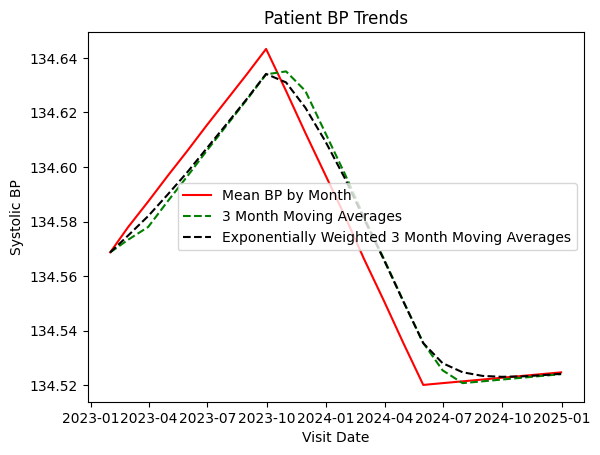

In [14]:
#plotting the trends over each other
plt.figure()
plt.plot(bp_monthly, label = 'Mean BP by Month', color = 'red')
plt.plot(bp_monthly_avgs, label = '3 Month Moving Averages', color = 'green', linestyle= '--')
plt.plot(bp_monthly_ewm, label = 'Exponentially Weighted 3 Month Moving Averages', color = 'black', linestyle= '--')
plt.xlabel('Visit Date')
plt.ylabel('Systolic BP')
plt.title('Patient BP Trends')
plt.legend()
plt.show()


##### Statistical Modeling Tasks

1. Analyze factors affecting baseline blood pressure:
   - Use statsmodels OLS to predict `bp_systolic`
   - Include `age`, `bmi`, `smoking`, and `diabetes` as predictors
   - Interpret the coefficients and their p-values
   - Assess model fit using R-squared and diagnostic plots
   - Tips:
     - Create feature matrix `X` with predictors and add constant term using `sm.add_constant()`
     - Use `sm.OLS(y, X).fit()` to fit the model
     - Use `summary()` to examine p-values and confidence intervals
     - Plot residuals vs fitted values and Q-Q plot
     - Consider robust standard errors with `HC3` covariance type

2. Model treatment effectiveness:
   - Fit a GLM with binomial family to predict treatment success
   - Use baseline characteristics and `adherence` as predictors
   - Report odds ratios and their confidence intervals
   - Assess model fit using deviance and diagnostic plots
   - Tips:
     - Create feature matrix `X` with predictors and add constant term
     - Use `sm.GLM(y, X, family=sm.families.Binomial()).fit()`
     - Get odds ratios with `np.exp(params)`
     - Check residual deviance vs null deviance
     - Use `influence()` to detect influential observations


In [15]:
#target variables and predictors
X = full_data[['age', 'bmi', 'smoking', 'diabetes']]
y = full_data['bp_systolic_baseline']

#constant
X = sm.add_constant(X)

#OLS Model
model = sm.OLS(y, X).fit()
print(model.summary())

                             OLS Regression Results                             
Dep. Variable:     bp_systolic_baseline   R-squared:                       0.376
Model:                              OLS   Adj. R-squared:                  0.376
Method:                   Least Squares   F-statistic:                     603.0
Date:                  Wed, 06 Nov 2024   Prob (F-statistic):               0.00
Time:                          05:24:12   Log-Likelihood:                -14803.
No. Observations:                  4000   AIC:                         2.962e+04
Df Residuals:                      3995   BIC:                         2.965e+04
Df Model:                             4                                         
Covariance Type:              nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        108.4929      0.998

In [16]:
#R squared value
R_squared = model.rsquared
print(R_squared)

0.37646882997065034


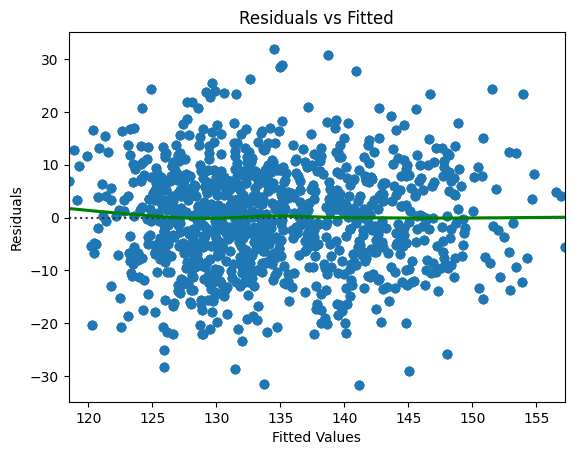

In [17]:
plt.figure()
sns.residplot(x=model.fittedvalues, y=model.resid, lowess=True, line_kws={'color': 'green'})
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted')
plt.show()

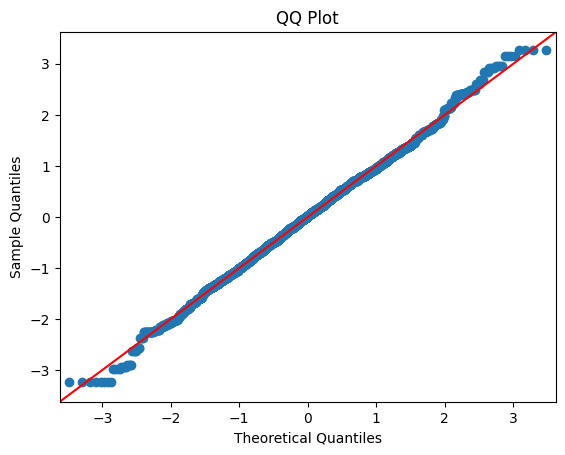

In [18]:
#Q-Q plots
sm.qqplot(model.resid, line = '45', fit = True)
plt.title('QQ Plot')
plt.show()

In [19]:
#HC3 Covariance Type
HC3_Covar_model = model.get_robustcov_results(cov_type='HC3')

print(HC3_Covar_model.summary())

                             OLS Regression Results                             
Dep. Variable:     bp_systolic_baseline   R-squared:                       0.376
Model:                              OLS   Adj. R-squared:                  0.376
Method:                   Least Squares   F-statistic:                     601.9
Date:                  Wed, 06 Nov 2024   Prob (F-statistic):               0.00
Time:                          05:24:24   Log-Likelihood:                -14803.
No. Observations:                  4000   AIC:                         2.962e+04
Df Residuals:                      3995   BIC:                         2.965e+04
Df Model:                             4                                         
Covariance Type:                    HC3                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        108.4929      0.985

In [20]:
#Model treatment effectiveness
X = full_data[['age', 'sex','bmi', 'smoking', 'diabetes','bp_systolic_baseline', 'cholesterol','heart_rate_baseline','adherence']]
y = full_data['outcome']

# Add the constant term
X = sm.add_constant(X)

In [21]:
#GLM Model fitting
GLM_model = sm.GLM(y, X, family=sm.families.Binomial()).fit()

print(GLM_model.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                outcome   No. Observations:                 4000
Model:                            GLM   Df Residuals:                     3990
Model Family:                Binomial   Df Model:                            9
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2568.9
Date:                Wed, 06 Nov 2024   Deviance:                       5137.8
Time:                        05:24:30   Pearson chi2:                 3.98e+03
No. Iterations:                     4   Pseudo R-squ. (CS):            0.04908
Covariance Type:            nonrobust                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -4.3375 

In [22]:
#Odds ratio and CI
odds_ratio = np.exp(GLM_model.params)
CI = np.exp(GLM_model.conf_int())

print(odds_ratio)
print(CI)

const                   0.013070
age                     1.001881
sex                     0.925642
bmi                     0.992188
smoking                 0.768155
diabetes                0.572442
bp_systolic_baseline    1.017250
cholesterol             1.006231
heart_rate_baseline     0.990072
adherence               7.404862
dtype: float64
                             0          1
const                 0.003827   0.044633
age                   0.996464   1.007328
sex                   0.811677   1.055609
bmi                   0.978168   1.006409
smoking               0.620012   0.951695
diabetes              0.475609   0.688989
bp_systolic_baseline  1.010448   1.024097
cholesterol           1.002968   1.009504
heart_rate_baseline   0.983941   0.996240
adherence             3.827437  14.326030


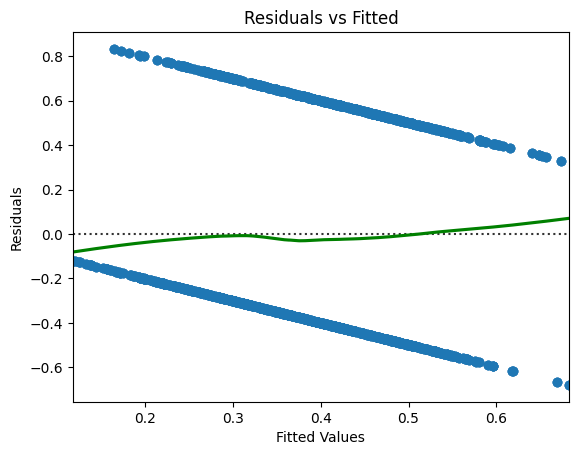

In [23]:
#Residuals vs Fitted Values

plt.figure()
sns.residplot(x = GLM_model.fittedvalues, y = GLM_model.resid_response, lowess = True, line_kws={'color': 'green'})
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted')
plt.show()

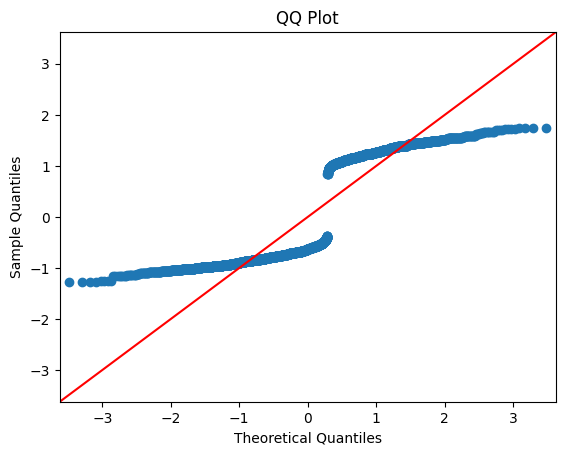

In [24]:
#QQ plot used as diagnostic plot

sm.qqplot(GLM_model.resid_deviance, line = '45', fit = True)
plt.title('QQ Plot')
plt.show()

In [26]:
#infuence calculations

inf = GLM_model.get_influence()
summ = inf.summary_frame()

print(summ)

            dfb_const   dfb_age   dfb_sex   dfb_bmi  dfb_smoking  \
visit_date                                                         
2023-01-17   0.015719  0.011071 -0.024234  0.002315    -0.024281   
2023-01-17   0.015719  0.011071 -0.024234  0.002315    -0.024281   
2023-01-17   0.015719  0.011071 -0.024234  0.002315    -0.024281   
2023-01-17   0.015719  0.011071 -0.024234  0.002315    -0.024281   
2023-01-17   0.015719  0.011071 -0.024234  0.002315    -0.024281   
...               ...       ...       ...       ...          ...   
2024-12-31  -0.022704 -0.002282 -0.017399 -0.004093    -0.026177   
2024-12-31  -0.022704 -0.002282 -0.017399 -0.004093    -0.026177   
2024-12-31  -0.022704 -0.002282 -0.017399 -0.004093    -0.026177   
2024-12-31  -0.022704 -0.002282 -0.017399 -0.004093    -0.026177   
2024-12-31  -0.022704 -0.002282 -0.017399 -0.004093    -0.026177   

            dfb_diabetes  dfb_bp_systolic_baseline  dfb_cholesterol  \
visit_date                                  